<a href="https://colab.research.google.com/github/Andru-1987/74235-_DataScience_I/blob/main/clase_8/clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [58]:
import pandas as pd


In [59]:
url_base = "https://raw.githubusercontent.com/Andru-1987/74235-_DataScience_I/refs/heads/main/clase_6/storage/acciones/"

symbols_map = {
    "D": "Dominion Energy Inc.",
    "EXC": "Exelon Corp.",
    "NEE": "NextEra Energy Inc.",
    "SO": "Southern Co.",
    "DUK": "Duke Energy Corp."
}


matched_file_names = {
    symbol: url_base + symbol + ".csv" for symbol in symbols_map.keys()
}

final_dataframe = []

for symbol_name, path_csv in matched_file_names.items():
    df = pd.read_csv(path_csv, sep=",")
    df["Name"] = symbols_map[symbol_name]
    final_dataframe.append(df)

final_dataframe = pd.concat(final_dataframe, ignore_index=True)
final_dataframe.columns = final_dataframe.columns.str.lower()

In [60]:
final_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6295 entries, 0 to 6294
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       6295 non-null   object 
 1   open       6295 non-null   float64
 2   high       6295 non-null   float64
 3   low        6295 non-null   float64
 4   close      6295 non-null   float64
 5   adj close  6295 non-null   float64
 6   volume     6295 non-null   int64  
 7   name       6295 non-null   object 
dtypes: float64(5), int64(1), object(2)
memory usage: 393.6+ KB


In [61]:
df = final_dataframe.copy()

In [62]:
from sklearn.preprocessing import StandardScaler

In [63]:
# Asegurarse de que la columna 'Date' esté como fecha
df['date'] = pd.to_datetime(df['date'])

# Agrupar por acción y calcular estadísticas
df_summary = df.groupby('name').agg({
    'open': ['mean', 'std'],
    'close': ['mean', 'std'],
    'high': 'mean',
    'low': 'mean',
    'volume': ['mean', 'std']
})
df_summary.columns = ['_'.join(col) for col in df_summary.columns]

# Variables X (sin la columna 'name' porque ya es el índice)
X = df_summary.copy()

# Estandarizar para clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [64]:
X

,open_mean,open_std,close_mean,close_std,high_mean,low_mean,volume_mean,volume_std
name,,,,,,,,
Dominion Energy Inc.,73.253765,4.187696,73.274940,4.182135,73.780842,72.697911,3.088129e+06,1.548809e+06
Duke Energy Corp.,80.261271,5.772322,80.282121,5.768632,80.831779,79.672311,3.293312e+06,1.208710e+06
Exelon Corp.,37.390866,5.701358,37.401541,5.697838,37.713288,37.062915,6.061571e+06,2.464832e+06
NextEra Energy Inc.,135.901096,31.715668,135.988372,31.725571,136.906990,134.906902,2.034481e+06,8.306920e+05
Southern Co.,47.859928,3.339557,47.887204,3.350945,48.193956,47.524496,5.283546e+06,2.061100e+06


1. Clustering con K-Means (No jerárquico)

In [65]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=0)
df_summary['cluster_kmeans'] = kmeans.fit_predict(X_scaled)


- ¿Por qué es adecuado?

    * Funciona bien si los datos tienen grupos esféricos
    * Rápido y eficiente para cientos de acciones
    * Nos permite elegir cuántos grupos queremos

- Limitación:

    * Requiere definir k
    * Sensible a valores extremos

2. Clustering Aglomerativo (Jerárquico)

In [66]:
from sklearn.cluster import AgglomerativeClustering

agglo = AgglomerativeClustering(n_clusters=3, linkage='ward')
df_summary['cluster_agglo'] = agglo.fit_predict(X_scaled)

- ¿Por qué podría funcionar?

    - No requiere inicialización ni supuestos fuertes
    - Útil para ver dendrogramas y relaciones entre acciones

- Limitación:

    - Escalabilidad (malo con miles de acciones)
    - Menos robusto con ruido

3. Clustering DBSCAN (Por densidad)


In [67]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=1.2, min_samples=2)
df_summary['cluster_dbscan'] = dbscan.fit_predict(X_scaled)

- ¿Por qué se usa?

    - Identifica outliers
    - Detecta clusters de formas arbitrarias

- ¿Por qué no es ideal aquí?

    - Esperamos que todas las acciones estén en clusters
    - No tenemos ruido, ni distribución espacial clara
    - Difícil de configurar los parámetros eps y min_samples

In [68]:
df_summary

,open_mean,open_std,close_mean,close_std,high_mean,low_mean,volume_mean,volume_std,cluster_kmeans,cluster_agglo,cluster_dbscan
name,,,,,,,,,,,
Dominion Energy Inc.,73.253765,4.187696,73.274940,4.182135,73.780842,72.697911,3.088129e+06,1.548809e+06,2,2,0
Duke Energy Corp.,80.261271,5.772322,80.282121,5.768632,80.831779,79.672311,3.293312e+06,1.208710e+06,2,2,0
Exelon Corp.,37.390866,5.701358,37.401541,5.697838,37.713288,37.062915,6.061571e+06,2.464832e+06,0,0,1
NextEra Energy Inc.,135.901096,31.715668,135.988372,31.725571,136.906990,134.906902,2.034481e+06,8.306920e+05,1,1,-1
Southern Co.,47.859928,3.339557,47.887204,3.350945,48.193956,47.524496,5.283546e+06,2.061100e+06,0,0,1


## Etapa de viz y prueba

In [69]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np

In [70]:
# Generar 15 acciones ficticias
np.random.seed(42)
n = 15

df_summary_test = pd.DataFrame({
    'Open_mean': np.random.uniform(50, 150, n),
    'Open_std': np.random.uniform(1, 5, n),
    'Close_mean': np.random.uniform(50, 150, n),
    'Close_std': np.random.uniform(1, 5, n),
    'High_mean': np.random.uniform(55, 155, n),
    'Low_mean': np.random.uniform(45, 145, n),
    'Volume_mean': np.random.uniform(1e5, 1e7, n),
    'Volume_std': np.random.uniform(1e4, 5e6, n),
}, index=[f'STOCK_{i}' for i in range(n)])


In [71]:
# Escalar
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_summary_test)


In [72]:
# K-Means clustering
df_summary_test['cluster_kmeans'] = kmeans.fit_predict(X_scaled)


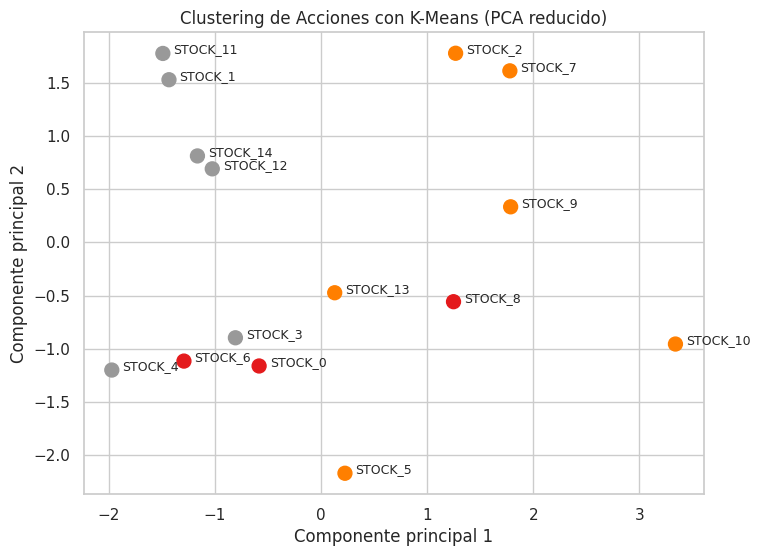

In [73]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Reducimos a 2D para graficar
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Graficar
plt.figure(figsize=(8,6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1],
                      c=df_summary_test['cluster_kmeans'],
                      cmap='Set1', s=100)

# Etiquetas
for i, name in enumerate(df_summary_test.index):
    plt.text(X_pca[i, 0]+0.1, X_pca[i, 1], name, fontsize=9)

plt.title("Clustering de Acciones con K-Means (PCA reducido)")
plt.xlabel("Componente principal 1")
plt.ylabel("Componente principal 2")
plt.grid(True)
plt.show()


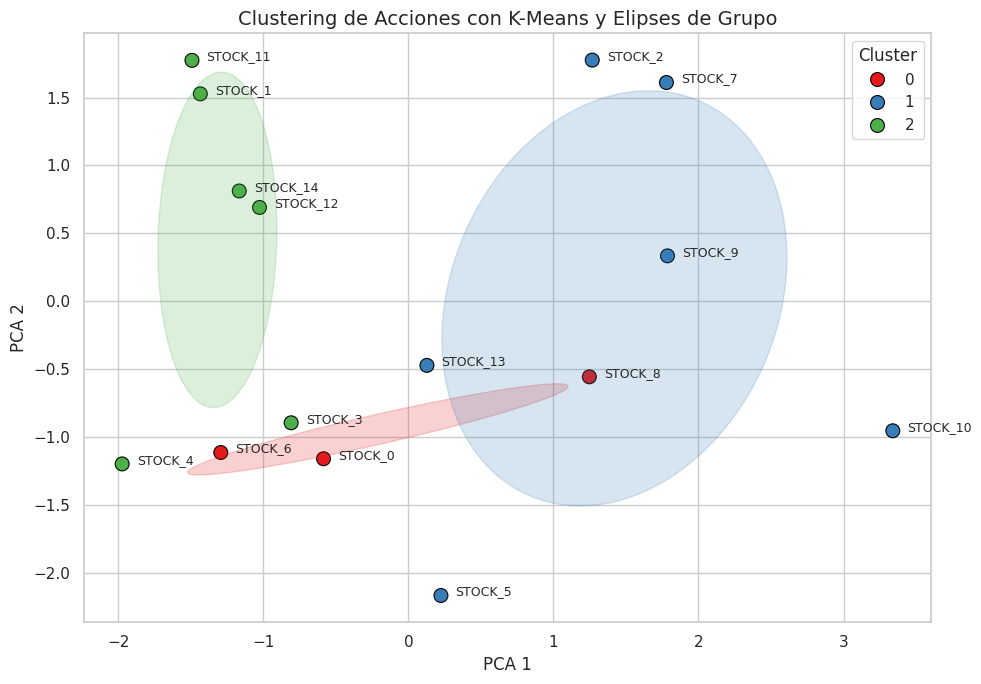

In [74]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import numpy as np
from sklearn.decomposition import PCA

# PCA a 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# DataFrame para graficar
df_plot = pd.DataFrame(X_pca, columns=["PCA1", "PCA2"], index=df_summary_test.index)
df_plot['cluster'] = df_summary_test['cluster_kmeans']

# Obtener la paleta de colores usada
palette = sns.color_palette("Set1", n_colors=len(df_plot['cluster'].unique()))
cluster_colors = {cluster: palette[i] for i, cluster in enumerate(sorted(df_plot['cluster'].unique()))}

# Función para dibujar una elipse
def draw_ellipse(position, covariance, ax, color, alpha=0.2):
    if covariance.shape == (2, 2):
        U, s, _ = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    ellipse = Ellipse(position, width, height, angle=angle, color=color, alpha=alpha)
    ax.add_patch(ellipse)

# Graficar
plt.figure(figsize=(10, 7))
ax = sns.scatterplot(
    data=df_plot,
    x="PCA1", y="PCA2",
    hue="cluster",
    palette=cluster_colors,
    s=100,
    edgecolor="black"
)

# Etiquetas de puntos
for i, name in enumerate(df_plot.index):
    plt.text(df_plot.iloc[i, 0] + 0.1, df_plot.iloc[i, 1], name, fontsize=9)

# Dibujar elipses
for cluster_id in df_plot['cluster'].unique():
    cluster_points = df_plot[df_plot['cluster'] == cluster_id][["PCA1", "PCA2"]]
    center = cluster_points.mean().values
    cov = np.cov(cluster_points.T)
    color = cluster_colors[cluster_id]
    draw_ellipse(center, cov, ax, color=color)

# Finalizar gráfico
plt.title("Clustering de Acciones con K-Means y Elipses de Grupo", fontsize=14)
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title="Cluster")
plt.grid(True)
plt.tight_layout()
plt.show()
